In [8]:
import numpy as np
import osqp
import matplotlib.pyplot as plt
from scipy import sparse
import control as ct
from casadi import *
import dpilqr
import itertools

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

In [11]:
from solvers.util import (
    compute_pairwise_distance,
    compute_pairwise_distance_nd_Sym,
    define_inter_graph_threshold,
    distance_to_goal,
    split_graph, 
    generate_f,
    generate_f_human_drone,
    objective,
    generate_min_max_input,
    generate_min_max_state
)


In [12]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = sparse.lil_matrix((6*n_agent, 6*n_agent))
    B_tot = sparse.lil_matrix((6*n_agent, 3*n_agent))
    A = sparse.csc_matrix([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = sparse.csc_matrix([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot
        
        
    

In [13]:
A_tot,B_tot = linear_kinodynamics(0.1,3)

In [207]:
from solvers import util

In [208]:
x0,xr = util.paper_setup_3_quads()

In [209]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))


In [210]:
def diag_block_mat_booliex(L):
    shp = L[0].shape
    mask = np.kron(np.eye(len(L)), np.ones(shp))==1
    out = np.zeros(np.asarray(shp)*len(L),dtype=int)
    out[mask] = np.concatenate(L).ravel()
    return out

In [211]:
def get_coll_cost(x, x_dims, radius, weight=200):
    distances = compute_pairwise_distance(x0, x_dims)
    pair_costs = np.fmin(np.zeros(1), distances - radius) ** 2
    return pair_costs.sum()*weight

In [212]:
def construct_P(P_base, num_agents):
    n = 6  # Dimension of state vector for each agent
    for i in range(num_agents):
        for j in range(num_agents):
            if i !=j:
                # Determine the position iices of agents i and j in the state vector
                pos_i = n * i  # Assuming each agent has 6 state vector components (3 positions + 3 velocities)
                pos_j = n * j

                # Modify the corresponding elements in P to incorporate collision avoidance
                # P_base[pos_i:pos_i + 3, pos_i:pos_i + 3] += np.eye(3) # (pos_i, pos_i)
                P_base[pos_i:pos_i + 3, pos_j:pos_j + 3] = np.eye(3)*50 # (pos_i, pos_j)
                P_base[pos_j:pos_j + 3, pos_i:pos_i + 3] = -np.eye(3)*50  # (pos_j, pos_i)
                # P_base[pos_j:pos_j + 3, pos_j:pos_j + 3] += np.eye(3) # (pos_j, pos_j)

    return P_base

## Solving the consensus ADMM problem with OSQP

In [213]:
import cvxpy as cp

In [214]:
def compute_pairwise_distance_CVX(X, x_dims, n_dims):
    """Analog to the above whenever some agents only use distance in the x-y plane"""
    CYLiER_RADIUS = 0.2

    n_states = x_dims[0]
    n_agents = len(x_dims)
    distances = []
    eps = 1e-3

    for i, n_dim_i in zip(range(n_agents), n_dims):
        for j, n_dim_j in zip(range(i + 1, n_agents), n_dims[i + 1 :]):
            n_dim = min(n_dim_i, n_dim_j)

            Xi = X[i * n_states : i * n_states + n_dim]
            Xj = X[j * n_states : j * n_states + n_dim]
            dX = Xi-Xj

            if n_dim == 3:
                # distances.append(cp.sqrt(dX[0]**2+dX[1]**2+dX[2]**2+eps))
                distances.append(cp.norm(dX))
            else:
                distances.append(cp.sqrt(dX[0]**2+dX[1]**2 + eps)+CYLiER_RADIUS)
    
    return distances

In [249]:
# Solving a MPC problem with OSQP solver at each iteration
N = 15

cost = 0
constr = []
x0,xr = util.paper_setup_3_quads()

radius = 0.3

# X_full = np.zeros((nsim+1,nx))
X_full = np.zeros((0,nx))
X_full = np.r_[X_full,x0.reshape(1,-1)]

U_full = np.zeros((0,nu))

xi = x0.flatten()
xr = xr.flatten()
Ad,Bd = linear_kinodynamics(0.1, 3)
n_agents = 3
nx = n_agents * 6
nu = n_agents * 3
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*n_agents)
QN = Q*500
R = 0.1*sparse.eye(nu)

iter = 0
x_dims = [n_states]*n_agents
n_dims = [3]*n_agents
obj_val = []
while not np.all(dpilqr.distance_to_goal(xi,xr,n_agents,6,3) < 0.1) and (iter <= 150):
# for _ in range(50):
    x = cp.Variable((N+1,nx))
    u = cp.Variable((N,nu))
    cost = 0
    constr = []
    
    # for t in range(N-1):
    #     cost += cp.quad_form(u[t+1,:]-u[t,:], np.eye(nu)) #control variation penalty

    for t in range(N):

        cost += cp.quad_form(x[t+1,:]-xr.flatten(),Q) + cp.quad_form(u[t,:],R)
        constr += [x[t + 1,:] == Ad @ x[t,:] + Bd @ u[t, :]]
        constr += [u[t,:] <= np.tile(np.array([3, 3, 3]),(n_agents,)) ]
        constr += [np.tile(np.array([-3, -3, -3]),(n_agents,)) <= u[t, :]]
        # constr += [x[t, :] <= np.tile(np.array([5, 5, 5, 3, 3, 3]),(n_agents,))]
        # constr += [np.tile(-np.array([-5, -5, -5, -3, -3, -3]),(n_agents,)) <= x[t,:]]
                    
        # Linearized collision avoidance constraints
        if iter > 0:
            x_prev = X_full[iter-1]
            # print(f'x_prev has shape {x_prev.shape}')
            for i in range(n_agents):
                for j in range(n_agents):
                    if j != i:
                        #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                        # A sequential convex programming approach" for the linearization step;
                        constr += [cp.norm(x_prev[j*n_states:j*n_states+3]-  \
                                           x_prev[i*n_states:i*n_states+3]) + \
                                (x_prev[j*n_states:j*n_states+3].T- \
                                 x_prev[i*n_states:i*n_states+3].T)/cp.norm(x_prev[j*n_states:j*n_states+3] \
                                -x_prev[i*n_states:i*n_states+3])@ \
                                   ((x[t,j*n_states:j*n_states+3]-x[t,i*n_states:i*n_states+3])- \
                                    (x_prev[j*n_states:j*n_states+3]-x_prev[i*n_states:i*n_states+3])) >= radius]

    cost += cp.quad_form((x[-1,:]-xr.flatten()),QN)    

    constr += [x[0, :] == xi]

    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose=True, warm_start = True)
    
    obj_val.append(problem.objective.value)

    u_trj = u.value
    x_trj = x.value
    ctrl = u_trj[1]
    xi = Ad@xi + Bd@ctrl
    X_full = np.r_[X_full,xi.reshape(1,-1)]
    U_full = np.r_[U_full, ctrl.reshape(1,-1)]
    
    iter +=1



                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 14 08:30:50 PM: Your problem has 423 variables, 46 constraints, and 0 parameters.
(CVXPY) Jun 14 08:30:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 14 08:30:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 14 08:30:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 14 08:30:50 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jun 14 08:30:50 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

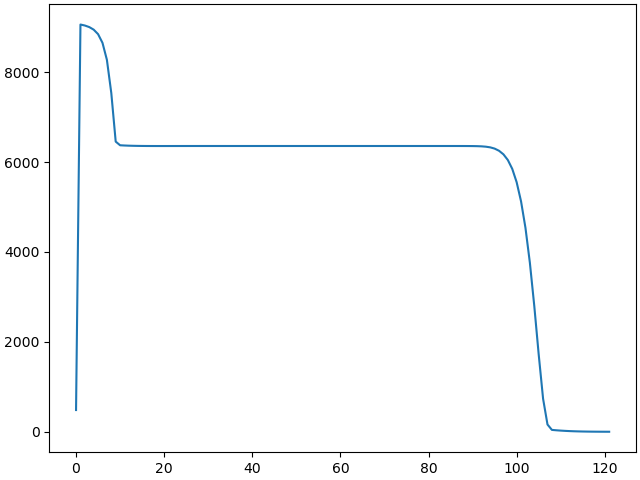

In [250]:
plt.figure()
plt.plot(obj_val)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


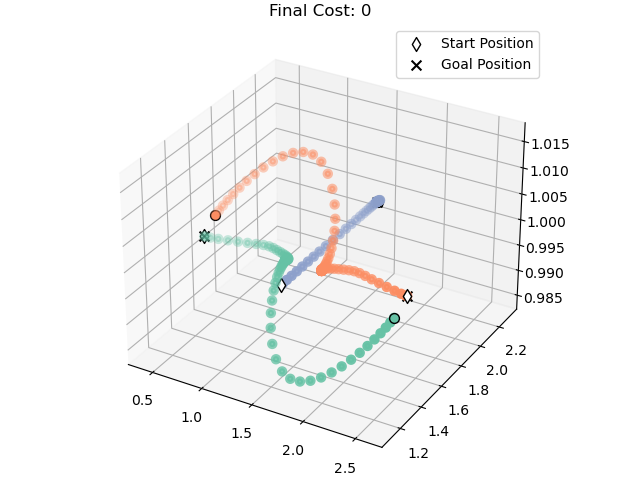

In [251]:
%matplotlib ipympl
plt.figure(dpi=100)
dpilqr.plot_solve(X_full,0,xr,[6,6,6],True,3)
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
# plt.savefig('MPC_with_OSQP.png')

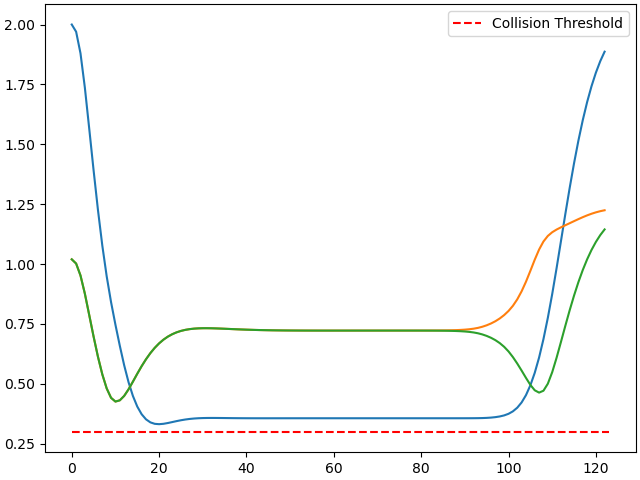

In [239]:
plt.figure(dpi=100)
plt.plot(np.arange(0,X_full.shape[0]),dpilqr.compute_pairwise_distance(X_full,[6,6,6],3));
plt.hlines(0.3,0, X_full.shape[0],linestyle='--', color='r',label='Collision Threshold')
plt.legend()

### Consensus-ADMM MPC

In [232]:
from solvers import util
from multiprocessing import Process, Pipe
import cvxpy as cp
# from multi_agent_scp import *

In [233]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# # Number of terms f_i.
# N = 3
# Ad,Bd = linear_kinodynamics(0.1,N)
# # A list of all the f_i.
# T = 15 #Prediction horizon
# n_states = 6
# n_inputs = 3
# Q_try = np.eye(n_states*N)
# R_try = np.eye(n_inputs*N)*0.1
# n = n_states*N

# x0, xr = util.paper_setup_3_quads()


# # f_list = []

# nx = n_states*N
# nu = n_inputs*N
# # x = cp.Variable(((T+1)*nx, 1))
# # u_input = cp.Variable((T*nu, 1))

    
# def run_worker(f, pipe):
#     T = 10
#     y_state = cp.Variable(((T+1) * nx + T * nu, 1))

#     Q = np.diag([1., 1., 1., 1., 1., 1.]* N)
#     x_dims = [6]*N
#     QN = Q*10

#     xbar = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu))
#     u = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu)) #This is the scaled Lagrange multiplier

#     rho = 1
#     f += (rho/2)*cp.sum_squares(y_state.flatten() - xbar + u)
#     x0, xr = util.paper_setup_3_quads()
#     constr = []
    
#     radius = 0.3   
#     # ADMM loop
#     iter = 0
#     while True:
#         try:
#             constr = []
#             constr += [y_state[0:nx] == x0]

#             for k in range(T):
#                 constr += [cp.reshape(y_state[:(T+1)*nx], [T+1, nx])[k+1,:] == Ad @ cp.reshape(y_state[:(T+1)*nx], [T+1, nx])[k] \
#                                                        + Bd @ cp.reshape(y_state[(T+1)*nx:], [T, nu])[k]]
#                 #Solve local constrained problem with OSQP solver in CVXPY
#                 if iter > 0 :
#                     for i in range(n_agents):
#                         for j in range(n_agents):
#                             if j != i:
#                                 #See "Generation of collision-free trajectories for a quadrocopter fleet: 
#                                 # A sequential convex programming approach" for the linearization step;
#                                 # for t in range(0,T+1):
#                                 pos_prev = state_prev[k,:]
#                                 pos_curr = cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[k]
                                
#                                 constr += [cp.norm(pos_prev[j*n_states:j*n_states+3]-  \
#                                                    pos_prev[i*n_states:i*n_states+3]) + \
#                                         (pos_prev[j*n_states:j*n_states+3].T- \
#                                          pos_prev[i*n_states:i*n_states+3].T)/cp.norm(pos_prev[j*n_states:j*n_states+3] \
#                                         -pos_prev[i*n_states:i*n_states+3])@ \
#                                            ((pos_curr[j*n_states:j*n_states+3] \
#                                             -pos_curr[i*n_states:i*n_states+3])- \
#                                 (pos_prev[j*n_states:j*n_states+3]- \
#                                  pos_prev[i*n_states:i*n_states+3]).flatten()) >= radius]


#             prox = cp.Problem(cp.Minimize(f),constr)
#             prox.solve()
#             pipe.send(y_state.value.flatten())
#             xbar.value = pipe.recv() #receive the averaged result from the main process.
#             # print(f'xbar has shape {xbar.value.shape} \n')
#             # print(f'y_state has shape {y_state.value.shape} \n')
#             u.value += y_state.value.flatten() - xbar.value


#             state_prev = y_state.value[:(T+1)*nx]
#             state_prev = state_prev.reshape((T+1, nx))

#             iter += 1
            
#             print(f'Current iteration is {iter}')
            
#         except EOFError:
#             print("Connection closed.")
#             break

# # Setup the workers.

# pipes = []
# procs = []
# for i in range(N):
#     local, remote = Pipe()
#     pipes += [local]
#     procs += [Process(target=run_worker, args=(construct_obj(nx, nu, xr, T, Q_try, R_try, N)[i], remote))]
#     procs[-1].start()

# # ADMM loop.
# solution_list = []
# for i in range(10):
#     # Gather and average xi

#     xbar = sum(pipe.recv() for pipe in pipes)/N
#     # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

#     solution_list.append(xbar)
#     # print(f'average of xbar is {np.mean(xbar)}\n')

#     # Scatter xbar
#     for pipe in pipes:
#         pipe.send(xbar)

# [p.terminate() for p in procs]

In [392]:
class AdmmMPC:
    def __init__(self, nx, nu, x0, xr, T, Q, R, Qf, N, Ad, Bd, ρ = 3, radius = 0.3, MAX_ITER=10):
        self.nx = nx #Total No. of states
        self.nu = nu #Total No. of inputs
        self.xr = xr #Final cond.
        self.x0 = x0 #Initial cond.
        self.N = N #No. of agents
        self.T = T #Horizon
        self.Q = Q #Positive definite
        self.R = R #Positive definite ..
        self.Qf = Qf #Positive definite
        self.radius = radius #Collision threshold radius
        self.Ad = Ad #State matrix
        self.Bd = Bd #Input matrix
        self.ρ = ρ
        self.MAX_ITER = MAX_ITER
        
        
    def objective_admm(self):
    
        """Compact form of quadratic tracking cost"""
        """y_aug: (x(0),x(1),...,x(N),u(0),...,u(N-1))"""
        
        # y_aug = self.y_state

#         objective = 0

#         # Quadratic objective
#         P = sparse.block_diag([sparse.kron(sparse.eye(self.T), self.Q), self.Qf,
#                            sparse.kron(sparse.eye(self.T), self.R)], format='csc')
#         # linear objective
#         q = np.hstack([np.kron(np.ones(self.T), -self.Q@self.xr.flatten()), -self.Qf@self.xr.flatten(), np.zeros(self.T*self.nu)])

#         objective += 1/2 * cp.quad_form(self.y_state, P) + q.T @ self.y_state #Quadratic tracking cost
        
        self.y_state = cp.Variable((((self.T+1)*self.nx + self.T * self.nu, 1))) #Augmented state variable
        cost = 0
        # x_trj_var = cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1, self.nx])
        # u_trj_var = cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])
        
        for t in range(N):
            
            cost += cp.quad_form(cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1, self.nx])[t+1,:]-xr.flatten(),self.Q) + \
            cp.quad_form(cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])[t,:],self.R)
        
        cost += cp.quad_form((cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1, self.nx])[-1,:]-xr.flatten()),self.Qf)    
 
        return cost
        

    def construct_obj_i(self):
        f_list = []
        for id in range(N):
            cost_i = self.objective_admm() #Objective of each augmented sub-system
            f_list.append(cost_i)

        return f_list 
    
    def solve_scp(self, obj):
        """Note that SCP works by iteratively improving the solution over the SAME HORIZON (it's not shifting)"""

        n = self.Q.shape[0]  # state dimension
        m = self.R.shape[0]  # control dimension

        # Initialize nominal trajectories
        # u_bar_base = np.tile(np.array([0., 0., 0.]), (1, self.N))
        u_bar_base = np.tile(np.random.rand(3)*0.01, (1, self.N))
        self.u_bar = np.tile(u_bar_base,(self.T, 1))
        self.s_bar = np.zeros((self.T + 1, n))
        self.s_bar[0] = self.x0.reshape(1,-1)
        for k in range(self.T):
            # s_bar[k+1] = fd(s_bar[k], u_bar[k])
            self.s_bar[k+1] = self.Ad @ self.s_bar[k] + self.Bd @ self.u_bar[k] #Linear dynamcis

        # Do SCP until convergence or maximum number of iterations is reached
        converged = False
        obj_prev = np.inf
        iterate = 0
        s_prev = None
        for i in range(30):
            s, u, _, obj_curr = self.scp_iteration(s_prev, iterate, obj)
            print(obj_curr)
            diff_obj = np.abs(obj_curr - obj_prev)
            prog_bar.set_postfix({'objective change': '{:.5f}'.format(diff_obj)})

            if diff_obj < tol:
                converged = True
                print('SCP converged after {} iterations.'.format(i))
                break
            else:
                obj_prev = obj_curr
                np.copyto(self.s_bar, s)
                np.copyto(self.u_bar, u)
                # ρ = ρ * 0.85

            s_prev = s
            iterate+=1

        if not converged:
            raise RuntimeError('SCP did not converge!')

        return s, u
    
    def scp_iteration(self, s_prev, iterate, obj):
        """Solve a single SCP sub-problem"""
        # A, B, c = linearize(fd, s_bar[:-1], u_bar)
        # A, B, c = np.array(A), np.array(B), np.array(c)
        # print(f'current iteration is {iterate}')
        n = self.Q.shape[0]
        m = self.R.shape[0]

        constr = []
        constr +=[self.y_state[0:self.nx] == self.s_bar[0].reshape(1,-1)]

        for k in range(self.T):
            
            constr += [cp.reshape(self.y_state[:(self.T+1)*self.nx], [self.T+1, self.nx])[k+1,:] \
                               == Ad @ cp.reshape(self.y_state[:(self.T+1)*self.nx], [self.T+1, self.nx])[k] \
                                   + Bd @ cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])[k]] 

            #Adding constraints for each quadrotor:
            if self.N > 1:

                for i in range(self.N):
                    """Convex trust region"""
                    constr += [cp.pnorm(cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1,self.nx])[k,i*6:(i+1)*6]-\
                                        self.s_bar.reshape(T+1,self.nx)[k,i*6:(i+1)*6],'inf') <= self.ρ]
                    
                    constr += [cp.pnorm(cp.reshape(self.y_state[(self.T+1)*self.nx:],[self.T, self.nu])[k,i*3:(i+1)*3]-\
                                        self.u_bar.reshape(T, self.nu)[k,i*3:(i+1)*3],'inf') <= self.ρ] 

                    constr += [np.array([-3, -3, -3]) <= cp.reshape(self.y_state[(self.T+1)*self.nx:],[self.T, self.nu])[k, i*3:(i+1)*3], \
                                cp.reshape(self.y_state[(self.T+1)*self.nx:],[self.T, self.nu])[k, i*3:(i+1)*3] <= np.array([3, 3, 3])]

                    #linearized collision avoidance constraints
                    if iterate > 0:
                        prev_pos = [s_prev[k][id:id+6] for id in range(0, len(s_prev[k]), 6)]
                        curr_pos = [cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1,self.nx])[k][id:id+6] for id in range(0, len(s_prev[k]), 6)]
                        for j in range(self.N):
                            if j != i:
                                constraints+= [cp.norm(prev_pos[i][0:3]-prev_pos[j][0:3]) + \
                                            (prev_pos[i][0:3].T-prev_pos[j][0:3].T)/cp.norm(prev_pos[i][0:3]-prev_pos[j][0:3])
                                            @ ((curr_pos[i][0:3]-curr_pos[j][0:3]) - (prev_pos[i][0:3]-prev_pos[j][0:3])) >= self.radius]

            else: #in case we want to test our code with a single drone

                constraints += [np.array([-3, -3, -3]) <= cp.reshape(self.y_state[(self.T+1)*self.nx:],[self.T, self.nu])[k, :], \
                                cp.reshape(self.y_state[(self.T+1)*self.nx:],[self.T, self.nu])[k, :] <= np.array([3, 3, 3])]

                constraints += [cp.pnorm(cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1,self.nx])[k,:]-self.s_bar[k,:],'inf') <= self.ρ]
                constraints += [cp.pnorm(cp.reshape(self.y_state[(self.T+1)*self.nx:],[self.T, self.nu])[k,:]-self.u_bar[k,:],'inf') <= self.ρ] 
        
        prob = cp.Problem(cp.Minimize(obj), constr)
        prob.solve(verbose = False)  

        if prob.status != 'optimal':
            raise RuntimeError('SCP solve failed. Problem status: ' + prob.status)

        s = self.y_state.value[:(self.T+1)*self.nx].reshape(self.T+1,self.nx)
        u = self.y_state.value[(self.T+1)*self.nx:].reshape(self.T, self.nu)

        obj_val = prob.objective.value

        return s, u, self.y_state.value, obj_val


    def run_worker(self, f, pipe):
        n_states = 6
        x_dims = [n_states]*self.N
        
        xbar = cp.Parameter((self.T+1)*self.nx + self.T*self.nu, value=np.zeros((self.T+1)*self.nx + self.T*self.nu))
        u = cp.Parameter((self.T+1)*self.nx + self.T*self.nu, value=np.zeros((self.T+1)*self.nx + self.T*self.nu)) 
        #This is the scaled Lagrange multiplier

        rho = 1
        f = 0
        f += (rho/2)*cp.sum_squares(self.y_state.flatten() - xbar + u)
        
        # ADMM loop
        admm_iter = 0
        while True:
            try:
#                 constr = []
#                 constr += [self.y_state[0:self.nx] == self.x0]

#                 for k in range(T):
#                     constr += [cp.reshape(self.y_state[:(self.T+1)*self.nx], [self.T+1, self.nx])[k+1,:] \
#                                == Ad @ cp.reshape(self.y_state[:(self.T+1)*self.nx], [self.T+1, self.nx])[k] \
#                                    + Bd @ cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])[k]]      

#                 #Solve local constrained problem with OSQP solver in CVXPY
#                 if admm_iter > 0:
#                     for t in range(T):
#                         pos_prev = state_prev[0]
#                         for i in range(self.N):
#                             for j in range(self.N):
#                                 if j != i:
#                                     #See "Generation of collision-free trajectories for a quadrocopter fleet: 
#                                     # A sequential convex programming approach" for the linearization step;
#                      #Each local mpc problem must be in RHC; otherwise cannot add linearized coll constraints
#                                     constr += [cp.norm(pos_prev[j*n_states:j*n_states+3]-  \
#                                     pos_prev[i*n_states:i*n_states+3]) + \
#                                     (pos_prev[j*n_states:j*n_states+3].T- \
#                                      pos_prev[i*n_states:i*n_states+3].T)/cp.norm(pos_prev[j*n_states:j*n_states+3] \
#                                     -pos_prev[i*n_states:i*n_states+3])@  \
#                                    ((cp.reshape(self.y_state[:(T+1)*nx],[T+1,nx])[t][j*n_states:j*n_states+3] \
#                                     -cp.reshape(self.y_state[:(T+1)*nx],[T+1,nx])[t][i*n_states:i*n_states+3])- \
#                                     (pos_prev[j*n_states:j*n_states+3]- \
#                                      pos_prev[i*n_states:i*n_states+3]).flatten()) >= self.radius]
                # prox = cp.Problem(cp.Minimize(f),constr)

                _, _, full_state_val, obj_val = self.solve_scp(f)
                # prox.solve(verbose=False)
                pipe.send(full_state_val.flatten())
                xbar.value = pipe.recv() #receive the averaged result from the main process.

                u.value += full_state_val.flatten() - xbar.value

                # state_prev = xbar.value[0:(T+1)*nx]
                # state_prev = state_prev.reshape((T+1, nx))

                admm_iter += 1
                print(f'Current ADMM iteration is {iter}\n')
            except EOFError:
                print("Connection closed.")
                break

    
    def run(self):
        # ADMM loop.
        
        pipes = []
        procs = []
        for i in range(self.N):
            local, remote = Pipe()
            pipes += [local]
            procs += [Process(target=self.run_worker, args=(self.construct_obj_i()[i], remote))]
            procs[-1].start()
        
        solution_list = []
        for i in range(self.MAX_ITER):
            # Gather and average xi

            xbar = sum(pipe.recv() for pipe in pipes)/N
            # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

            solution_list.append(xbar)
            # print(f'average of xbar is {np.mean(xbar)}\n')

            # Scatter xbar
            for pipe in pipes:
                pipe.send(xbar)
        
        [p.terminate() for p in procs]
        
        
        return solution_list

        


In [393]:
x0.shape

(18, 1)

In [394]:
N = 3
Ad,Bd = linear_kinodynamics(0.1,N)
# A list of all the f_i.
T = 15 #Prediction horizon
n_states = 6
n_inputs = 3
# Q_try = np.eye(n_states*N)
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*N)
QN = Q*500
R = 0.1*sparse.eye(N*n_inputs)
n = n_states*N

x0, xr = util.paper_setup_3_quads()


# f_list = []

nx = n_states*N
nu = n_inputs*N

In [396]:
sub_problem = AdmmMPC(nx, nu, x0, xr, T, Q, R, QN, N, Ad, Bd , ρ = 2, MAX_ITER = 5)

In [397]:
sol_list = sub_problem.run()

Process Process-145:
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_28690/2316579035.py", line 212, in run_worker
    _, _, full_state_val, obj_val = self.solve_scp(f)
  File "/tmp/ipykernel_28690/2316579035.py", line 81, in solve_scp
    s, u, _, obj_curr = self.scp_iteration(s_prev, iterate, obj)
  File "/tmp/ipykernel_28690/2316579035.py", line 157, in scp_iteration
    raise RuntimeError('SCP solve failed. Problem status: ' + prob.status)
RuntimeError: SCP solve failed. Problem status: infeasible
Process Process-146:


EOFError: 

Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_28690/2316579035.py", line 212, in run_worker
    _, _, full_state_val, obj_val = self.solve_scp(f)
Process Process-147:
  File "/tmp/ipykernel_28690/2316579035.py", line 81, in solve_scp
    s, u, _, obj_curr = self.scp_iteration(s_prev, iterate, obj)
  File "/tmp/ipykernel_28690/2316579035.py", line 157, in scp_iteration
    raise RuntimeError('SCP solve failed. Problem status: ' + prob.status)
Traceback (most recent call last):
RuntimeError: SCP solve failed. Problem status: infeasible
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randyche